In [ ]:
%matplotlib inline


数据加载和处理教程
====================================
**作者**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

在解决机器学习问题时, 我们需要付出很多努力来准备数据, 为了使代码更具可读性, 
PyTorch提供了许多工具来使数据加载变得简单易行. 在本教程中, 我们将要学习如何对
一个重要的数据集进行加载、预处理\数据增强. 

为了运行本教程, 请确保以下包已经安装:

-  ``scikit-image``: 用来读取图片和图像变换
-  ``pandas``: 更方便地解析csv文件




In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # 交互模式

我们将要处理的是面部姿态的数据集, 其中一张人脸图像如下图一样被标注出来. 
下面是一张脸的标注:

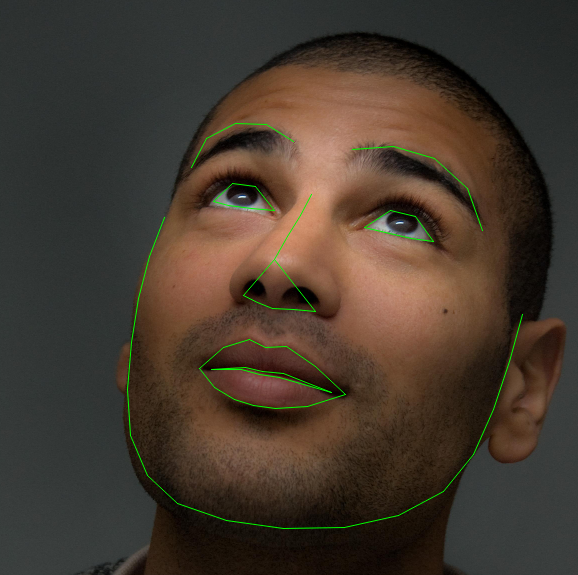

每张人脸图像上, 总共有68个不同的标注点被标记出来. 

<div class="alert alert-info"><h4>Note</h4><p>点击 [这里](https://download.pytorch.org/tutorial/faces.zip)下载数据集, 
    这些图像在目录 ' faces/ '下. 
    这个数据集实际上是从imagenet数据集中选取标记为人脸的一些图片, 
    使用`dlib's pose estimation <http://blog.dlib.net/2014/08/real-time-face-pose-estimation.html>`__
    方法生成的.</p></div>

数据集中的csv文件记录着标注信息, 像下面这样: 


```
    image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x, ... ,part_67_x,part_67_y
    0805personali01.jpg,27,83,27,98, ... 84,134
    1084239450_e76e00b7e7.jpg,70,236,71,257, ... ,128,312
```


让我们快速地读取CSV文件, 以(N,2)的数组形式获得标记点, 其中N表示标记点的个数. 




In [2]:
!wget https://download.pytorch.org/tutorial/faces.zip

--2018-08-14 21:10:03--  https://download.pytorch.org/tutorial/faces.zip
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:2012:0:d:607e:4540:93a1, 2600:9000:2012:f400:d:607e:4540:93a1, 2600:9000:2012:8600:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:2012:0:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5780252 (5.5M) [application/zip]
Saving to: ‘faces.zip’

faces.zip           100%[===================>]   5.51M   904KB/s    in 10s     

2018-08-14 21:10:14 (564 KB/s) - ‘faces.zip’ saved [5780252/5780252]



In [4]:
ls;unzip faces.zip

01_tensor_tutorial.ipynb             09_data_loading_tutorial.ipynb
02_autograd_tutorial.ipynb           data/
03_neural_networks_tutorial.ipynb    faces.zip
04_cifar10_tutorial.ipynb            hymenoptera_data/
05_data_parallel_tutorial.ipynb      mnist/
06_save_load_model.ipynb             net_params.pkl
07_MNIST.ipynb                       net.pkl
08_transfer_learning_tutorial.ipynb  nohup.out
Archive:  faces.zip
   creating: faces/
  inflating: faces/0805personali01.jpg  
  inflating: faces/1084239450_e76e00b7e7.jpg  
  inflating: faces/10comm-decarlo.jpg  
  inflating: faces/110276240_bec305da91.jpg  
  inflating: faces/1198_0_861.jpg    
  inflating: faces/137341995_e7c48e9a75.jpg  
  inflating: faces/1383023626_8a49e4879a.jpg  
  inflating: faces/144044282_87cf3ff76e.jpg  
  inflating: faces/152601997_ec6429a43c.jpg  
  inflating: faces/1549040388_b99e9fa295.jpg  
  inflating: faces/1878519279_f905d4f34e.jpg  
  inflating: faces/2046713398_91aaa6fe1c.jpg  
  inflating: faces/21

In [6]:
ls;rm faces.zip

01_tensor_tutorial.ipynb             data/
02_autograd_tutorial.ipynb           faces/
03_neural_networks_tutorial.ipynb    faces.zip
04_cifar10_tutorial.ipynb            hymenoptera_data/
05_data_parallel_tutorial.ipynb      mnist/
06_save_load_model.ipynb             net_params.pkl
07_MNIST.ipynb                       net.pkl
08_transfer_learning_tutorial.ipynb  nohup.out
09_data_loading_tutorial.ipynb


In [7]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


我们写一个函数来显示一张图片和它的标记点, 然后用这个函数来显示一个样本. 




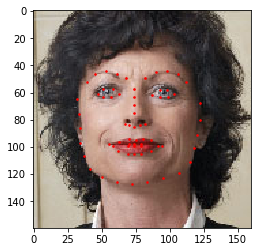

In [8]:
def show_landmarks(image, landmarks):
    """显示带标记点的图片"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 暂停一下, 使plots更新

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

Dataset类
-------------

``torch.utils.data.Dataset`` 是一个表示数据集的抽象类. 
你自己的数据集一般应该继承``Dataset``, 并且重写下面的方法:  

-  ``__len__`` 使用``len(dataset)`` 可以返回数据集的大小
-  ``__getitem__`` 支持索引, 以便于使用 ``dataset[i]`` 可以
   获取第$i$个样本(0索引)

我们为我们的人脸数据集创建一个数据集类.  我们使用
``__init__``方法来读取csv文件, 使用 ``__getitem__``读取图片. 
这样可以使内存高效利用, 因为我们并不需要在内存中一次存储所有图片, 
而是按照需要读取. 

数据集的一个样例是一个``{'image': image, 'landmarks': landmarks}``样的字典. 
数据集类中有一个可选的参数 ``transform`` 这样可以对数据集做任何需要的处理. 
我们将在下节看到 ``transform`` 的用处. 




In [9]:
class FaceLandmarksDataset(Dataset):
    """人脸标记数据集"""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): 带有标记点的csv文件路径
            root_dir (string): 图片路径
            transform (callable, optional):可选择进行的图像变换
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

让我们实例化这个类 并且迭代所有的数据样本.  我们将打印前4个样本, 并显示它们的标记点. 




0 (324, 215, 3) (68, 2)


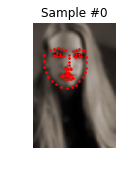

1 (500, 333, 3) (68, 2)


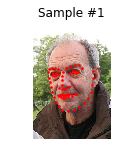

2 (250, 258, 3) (68, 2)


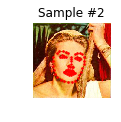

3 (434, 290, 3) (68, 2)


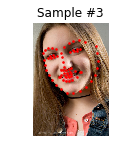

In [10]:
face_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                    root_dir='faces/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

Transforms
----------

我们可以看到上面输出的样例中的图像并不是同一尺寸的图片. 大多数神经网络需要输入
一个固定大小的图像, 因此我们需要写代码来处理. 
让我们创建三个transform操作:

-  ``Rescale``: 修改图片尺寸
-  ``RandomCrop``: 随机裁切图片, 这是数据增强的方法
-  ``ToTensor``: 将numpy格式的图片转为torch格式的图片（我们需要交换坐标轴）

我们不将它们写成简单的函数, 而是写成可以调用的类, 这样transform的参数不需要每次都传递
如果需要的话, 我们只需实现 ``__call__`` 方法和``__init__`` 方法.之后我们可以像下面这
样使用transform:

```
    tsfm = Transform(params)
    transformed_sample = tsfm(sample)
```


观察下面这些变换如何同时对图像和标记点改变的. 




In [11]:
class Rescale(object):
    """按照给定尺寸更改一个图像的尺寸

    Args:
        output_size (tuple or int): 要求输出的尺寸.  如果是个元组类型, 输出
        和output_size匹配. 如果时int类型,图片的短边和output_size匹配, 图片的
        长宽比保持不变. 
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # 对于标记点, h和w需要交换位置, 因为对于图像, x和y分别时第1维和第0维
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """随机裁剪图片

    Args:
        output_size (tuple or int): 期望输出的尺寸, 如果时int类型, 裁切成正方形. 
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """将ndarrays的样本转化为Tensors的样本"""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        # 交换颜色通道, 因为
        # numpy图片: H x W x C
        # torch图片   : C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

### Compose transforms


现在我们就将 transform 应用在一个样本上. 

如果我们想将图片的短边变为256像素, 并且随后随机裁切成224像素的正方形. 
i.e, 我们可以组合``Rescale``和``RandomCrop``变换. 
``torchvision.transforms.Compose`` 就是一个可以做这样一个组合的可调用的类. 




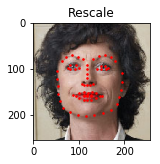

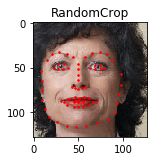

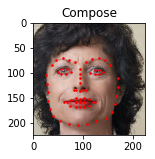

In [12]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# 对每个样本进行上面的每一个操作. 
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

迭代整个数据集
-----------------------------

让我们进行所有操作, 来创建结合了图像变换的数据集
总之, 每次迭代的数据: 

-  从文件中读取图像
-  对所读的图像上应用变换
-  其中一个变换是随机的, 所以可以增强数据样本

我们可以像之前一样用 ``for i in range`` 循环从已创建的数据集中迭代




In [13]:
transformed_dataset = FaceLandmarksDataset(csv_file='faces/face_landmarks.csv',
                                           root_dir='faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


然而我们用简单的``for``循环来迭代整个数据集会丢失很多特点, 
特别地, 我们会丢失:

-  批读取数据
-  打乱数据顺序
-  使用``multiprocessing``并行加载数据

``torch.utils.data.DataLoader`` 是提供了所有上述特点的迭代器. 
下面使用的参数应该很清晰. 其中一个有趣的参数是``collate_fn``. 
你可以使用``collate_fn``来指定如何精确地读取一批的样本. 
然而, 默认的collate在大部分的情况下都表现得很好




0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


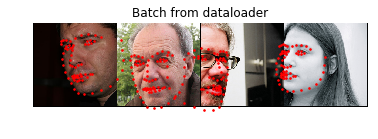

In [14]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# 定义一个函数来查看某个 batch 的数据样本图片和标记点
def show_landmarks_batch(sample_batched):
    """显示指定 batch 的数据样本的图片和标记点"""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # 观察到第四批数据时停止
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

后记: torchvision
----------------------

在这个教程中, 我们学习了如何写和使用数据集, 图像变换和dataloder. 
``torchvision`` 提供了常用的数据集和图像变换, 或许你甚至不必写自定义的类和变换. 
在torchvision中一个最经常用的数据集是``ImageFolder``. 它要求数据按下面的形式存放



    root/ants/xxx.png
    root/ants/xxy.jpeg
    root/ants/xxz.png
    .
    .
    .
    root/bees/123.jpg
    root/bees/nsdf3.png
    root/bees/asd932_.png



'ants', 'bees' 等是图像的类标. 同样, ``PIL.Image`` 中出现的一般的图像变换像
``RandomHorizontalFlip``, ``Scale`` 也是可以使用的. 
你可以像下面这样用这些函数来写dataloader:


    import torch
    from torchvision import transforms, datasets

    data_transform = transforms.Compose([
          transforms.RandomSizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
      ])
    hymenoptera_dataset = datasets.ImageFolder(root='hymenoptera_data/train',
                                             transform=data_transform)
    dataset_loader = torch.utils.data.DataLoader(hymenoptera_dataset,
                                               batch_size=4, shuffle=True,
                                               num_workers=4)

关于训练代码的例子, 请看
`transfer_learning_tutorial`.

